In [48]:
import datetime
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import itertools
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [9]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

In [10]:
for c in train.columns:
    if train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [11]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [14]:
y_train = train["y"]
y_mean = np.average(y_train)
y_mean

100.66931812782134

In [42]:
xgb_params = {
    "n_trees": 500,
    "eta": 0.005,
    "max_depth": 4,
    "subsample": 0.95,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "base_score": y_mean,
    "silent": 1
}

In [16]:
dtrain = xgb.DMatrix(train.drop("y", axis=1), y_train)
dtest = xgb.DMatrix(test)

In [17]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=50, 
#                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:12.64	test-rmse:12.638
[50]	train-rmse:11.092	test-rmse:11.1459
[100]	train-rmse:10.0189	test-rmse:10.1351
[150]	train-rmse:9.28968	test-rmse:9.47303
[200]	train-rmse:8.80062	test-rmse:9.05063
[250]	train-rmse:8.47291	test-rmse:8.78791
[300]	train-rmse:8.25098	test-rmse:8.62768
[350]	train-rmse:8.0908	test-rmse:8.53291
[400]	train-rmse:7.95357	test-rmse:8.47836
[450]	train-rmse:7.82536	test-rmse:8.4491
[500]	train-rmse:7.70952	test-rmse:8.43563
[550]	train-rmse:7.61704	test-rmse:8.42952
[600]	train-rmse:7.53256	test-rmse:8.42824


In [27]:
# CV, 750, 1250, 1500
num_boost_rounds = 1250
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

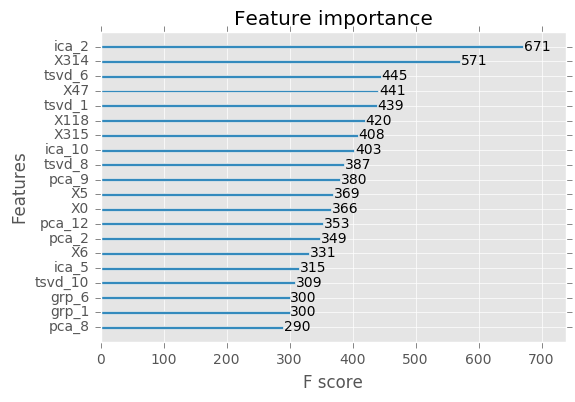

In [28]:
xgb.plot_importance(model, max_num_features=20)

In [31]:
y_pred = model.predict(dtrain)

In [32]:
r2_score(y_train, y_pred)

0.68658199455340752

In [43]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=50, 
                   verbose_eval=50, show_stdv=False)
num_boost = [len(cv_output), 750, 1250, 1500]
r2_value = []
prediction = []

for i in num_boost:
    print(i)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=i)
    y_pred_train = model.predict(dtrain)
    y_pred_test = model.predict(dtest)
    r2_value.append(r2_score(y_train, y_pred_train))
    prediction.append(y_pred_test)


[0]	train-rmse:12.64	test-rmse:12.638
[50]	train-rmse:11.092	test-rmse:11.1459
[100]	train-rmse:10.0189	test-rmse:10.1351
[150]	train-rmse:9.28968	test-rmse:9.47303
[200]	train-rmse:8.80062	test-rmse:9.05063
[250]	train-rmse:8.47291	test-rmse:8.78791
[300]	train-rmse:8.25098	test-rmse:8.62768
[350]	train-rmse:8.0908	test-rmse:8.53291
[400]	train-rmse:7.95357	test-rmse:8.47836
[450]	train-rmse:7.82536	test-rmse:8.4491
[500]	train-rmse:7.70952	test-rmse:8.43563
[550]	train-rmse:7.61704	test-rmse:8.42952
[600]	train-rmse:7.53256	test-rmse:8.42824
576
750
1250
1500


## Prediction

In [44]:
y_predict = model.predict(dtest)

In [45]:
y_predict

array([  85.18135071,   97.18682861,   80.05259705, ...,   93.39948273,
        109.8515625 ,   93.75300598], dtype=float32)

In [46]:
r2_value

[0.61848415826468184,
 0.64248259587514533,
 0.68658199455340752,
 0.70297983205481929]

In [60]:
mean_values = pd.DataFrame.transpose(pd.DataFrame(prediction)).mean(axis=1)

In [61]:
output = pd.DataFrame({"ID": test.index, "y": mean_values})

In [63]:
output.to_csv("submissions_xgb_average.csv", index=False)

In [65]:
test

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
ID,,,,,,,,,,,,,,,,,,,,,
1,24,23,38,5,3,26,0,22,0,0,...,-1.714782,0.003638,1.250838,7.046348,1.271178,3.610562,-0.021043,2.593055,26.800662,2.542356
2,46,3,9,0,3,9,6,24,0,0,...,0.170500,-0.013091,0.158002,7.160356,5.084712,-0.177144,-0.024816,-1.128290,8.807027,5.084712
3,24,23,19,5,3,0,9,9,0,0,...,-0.982514,0.012243,0.828812,3.644108,3.813534,3.307781,0.006142,1.492705,6.044545,2.542356
4,24,13,38,5,3,32,11,13,0,0,...,-1.891332,-0.007817,1.165267,1.205195,2.542356,3.900539,-0.003266,3.635485,29.311298,2.542356
5,49,20,19,2,3,31,8,12,0,0,...,0.372387,0.016720,-0.412456,6.412039,2.542356,0.203514,-0.005647,0.534005,18.929148,3.813534
8,51,1,9,4,3,30,6,18,0,0,...,2.187761,-0.017054,-1.890669,8.139587,5.084712,0.996816,-0.012483,-0.702531,13.857533,3.813534
10,50,3,5,3,3,30,3,24,0,0,...,-2.170699,-0.012379,1.900214,14.435411,6.355890,-0.364884,-0.027055,0.455819,16.827351,1.271178
11,32,20,5,2,3,14,3,0,0,0,...,-0.309360,0.021801,-0.046182,3.499716,3.813534,0.205489,0.025721,0.900369,7.723744,3.813534
12,15,13,43,2,3,14,9,13,0,0,...,-1.558666,0.001382,3.041812,-3.430354,6.355890,-0.332851,-0.001156,-3.055479,20.151320,3.813534
